In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn
from PIL import Image
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import os.path

In [2]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
RANDOM_STATE = 42
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
METRICS = [
    "accuracy",
    "precision",
    "recall"
]

In [3]:

def get_dataset():
    main_directory = "Fish_Dataset/Fish_Dataset"
    images = []
    labels = []
    for directory in tqdm(os.listdir(main_directory)):
        next_directory = f"{main_directory}/{directory}"
        if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
            continue
        for images_directory in os.listdir(next_directory):
            if "GT" not in images_directory:
                final_directory = f"{next_directory}/{images_directory}"
                for image in os.listdir(final_directory):
                    images.append(np.array(Image.open(f"{final_directory}/{image}").resize((224, 224)))/255)
                    labels.append(images_directory)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels





def plot_training_images(images, labels):
    plot_images = []
    plot_labels = []
    for i, j in zip(images, labels):
        if j in plot_labels:
            continue
        else:
            plot_images.append(i)
            plot_labels.append(j)
    fig, axes = plt.subplots(nrows = 3, ncols = 3, sharex=False, figsize=(12, 12))
    for i in range(3):
        for j in range(3):
            axes[i][j].imshow(plot_images[i * 3 + j])
            axes[i][j].set_xlabel(plot_labels[i * 3 + j])
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
    plt.tight_layout()
    plt.show()


def get_tf_dataset(images, labels):
    return tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE).prefetch(1)


def split_dataset(images, labels, test_size = 0.2, valid_size = 0.2):
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = test_size, random_state = RANDOM_STATE)
    train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size = valid_size, random_state = RANDOM_STATE)
    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)


def plot_cm(test_labels, prediction_labels, encoder):
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(test_labels, prediction_labels)
    df_cm = pd.DataFrame(cm, index = [i for i in encoder.categories_[0]],columns = [i for i in encoder.categories_[0]])
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
    plt.show()


def plot_history(history):
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 10))
 # Training
    axes[0][0].plot(range(1, len(history.history["loss"]) + 1), history.history["loss"], label='train')
    axes[0][1].plot(range(1, len(history.history["accuracy"]) + 1), history.history["accuracy"], label='train')
    axes[1][0].plot(range(1, len(history.history["precision"]) + 1), history.history["precision"], label='train')
    axes[1][1].plot(range(1, len(history.history["recall"]) + 1), history.history["recall"], label='train')

# Validation
    axes[0][0].plot(range(1, len(history.history["val_loss"]) + 1), history.history["val_loss"], label='val')
    axes[0][1].plot(range(1, len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"], label='val')
    axes[1][0].plot(range(1, len(history.history["val_precision"]) + 1), history.history["val_precision"], label='val')
    axes[1][1].plot(range(1, len(history.history["val_recall"]) + 1), history.history["val_recall"], label='val')

  
    axes[0][0].set_title("Loss Comparison", fontdict = {'fontsize': 20})
    axes[0][0].set_xlabel("Epoch")
    axes[0][0].set_ylabel("Loss")

    axes[0][1].set_title("Accuracy Comparison", fontdict = {'fontsize': 20})
    axes[0][1].set_xlabel("Epoch")
    axes[0][1].set_ylabel("Accuracy")

    axes[1][0].set_title("Precision Comparison", fontdict = {'fontsize': 20})
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Precision")

    axes[1][1].set_title("Recall Comparison", fontdict = {'fontsize': 20})
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("Recall")
    plt.tight_layout()
    plt.show()


def get_resnet(categories):
    conv_block = tf.keras.applications.resnet.ResNet50(include_top = False, weights = "imagenet")
    output = tf.keras.layers.GlobalAveragePooling2D()(conv_block.output)
    output = tf.keras.layers.Dense(categories, activation = "softmax")(output)
    model = tf.keras.Model(inputs = [conv_block.input], outputs = [output])
    return model, "ResNet50"

In [4]:
images, labels = get_dataset()
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)
encoder = OneHotEncoder(sparse = False)
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1))
valid_labels = encoder.transform(valid_labels.reshape(-1, 1))
test_labels = encoder.transform(test_labels.reshape(-1, 1))
train_dataset = get_tf_dataset(train_images, train_labels)
valid_dataset = get_tf_dataset(valid_images, valid_labels)

100%|██████████| 12/12 [03:41<00:00, 18.44s/it]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


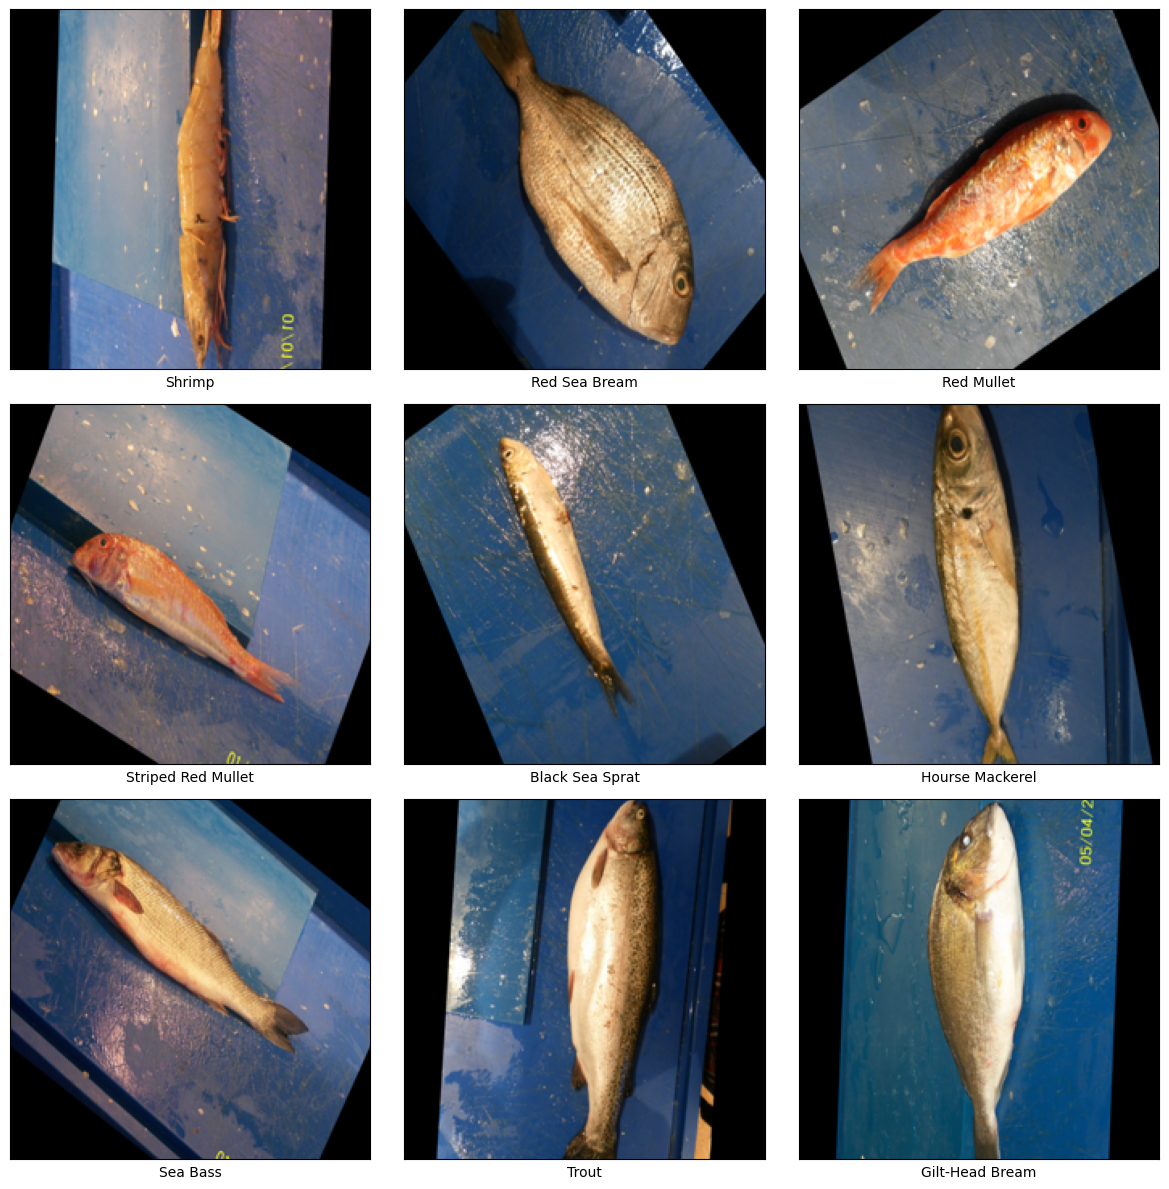

In [5]:
plot_training_images(train_images, encoder.inverse_transform(train_labels).reshape(-1,))

In [6]:
model, model_name = get_resnet(len(encoder.categories_[0]))
config_defaults = {
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "model_name": model_name,
    "loss": LOSS,
    "random_state": RANDOM_STATE,
    "optimizer": OPTIMIZER,
    "metrics": METRICS
}
model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [7]:
history = model.fit(train_dataset,
                    validation_data = valid_dataset, 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights = True))

Epoch 1/100


180/180 [==============================] - 1709s 9s/step - loss: 0.3746 - accuracy: 0.8920 - precision: 0.9228 - recall: 0.8573 - val_loss: 33.2625 - val_accuracy: 0.1069 - val_precision: 0.1069 - val_recall: 0.1069
Epoch 2/100
180/180 [==============================] - 1649s 9s/step - loss: 0.0693 - accuracy: 0.9771 - precision: 0.9799 - recall: 0.9755 - val_loss: 84.9668 - val_accuracy: 0.1069 - val_precision: 0.1069 - val_recall: 0.1069
Epoch 3/100
180/180 [==============================] - 1247s 7s/step - loss: 0.0526 - accuracy: 0.9851 - precision: 0.9868 - recall: 0.9832 - val_loss: 28.9743 - val_accuracy: 0.1069 - val_precision: 0.1069 - val_recall: 0.1069
Epoch 4/100
180/180 [==============================] - 1162s 6s/step - loss: 0.0392 - accuracy: 0.9880 - precision: 0.9885 - recall: 0.9877 - val_loss: 19.3729 - val_accuracy: 0.1069 - val_precision: 0.1069 - val_recall: 0.1069
Epoch 5/100
180/180 [==============================] - 1134s 6s/step - loss: 0.0044 - 

In [8]:
result_inter = model.predict(test_images)
prediction_index = np.argmax(result_inter, axis = -1)
result = np.zeros(shape = test_labels.shape, dtype = test_labels.dtype)
for i in range(result.shape[0]):
    result[i][prediction_index[i]] = 1.0

57/57 [==============================] - 95s 2s/step


In [9]:
test_labels = encoder.inverse_transform(test_labels)
prediction_labels = encoder.inverse_transform(result)

In [10]:
print(classification_report(test_labels, prediction_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       195
   Gilt-Head Bream       1.00      1.00      1.00       211
   Hourse Mackerel       1.00      1.00      1.00       179
        Red Mullet       1.00      0.99      0.99       191
     Red Sea Bream       1.00      1.00      1.00       203
          Sea Bass       1.00      1.00      1.00       207
            Shrimp       1.00      1.00      1.00       209
Striped Red Mullet       0.99      1.00      1.00       204
             Trout       1.00      1.00      1.00       201

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



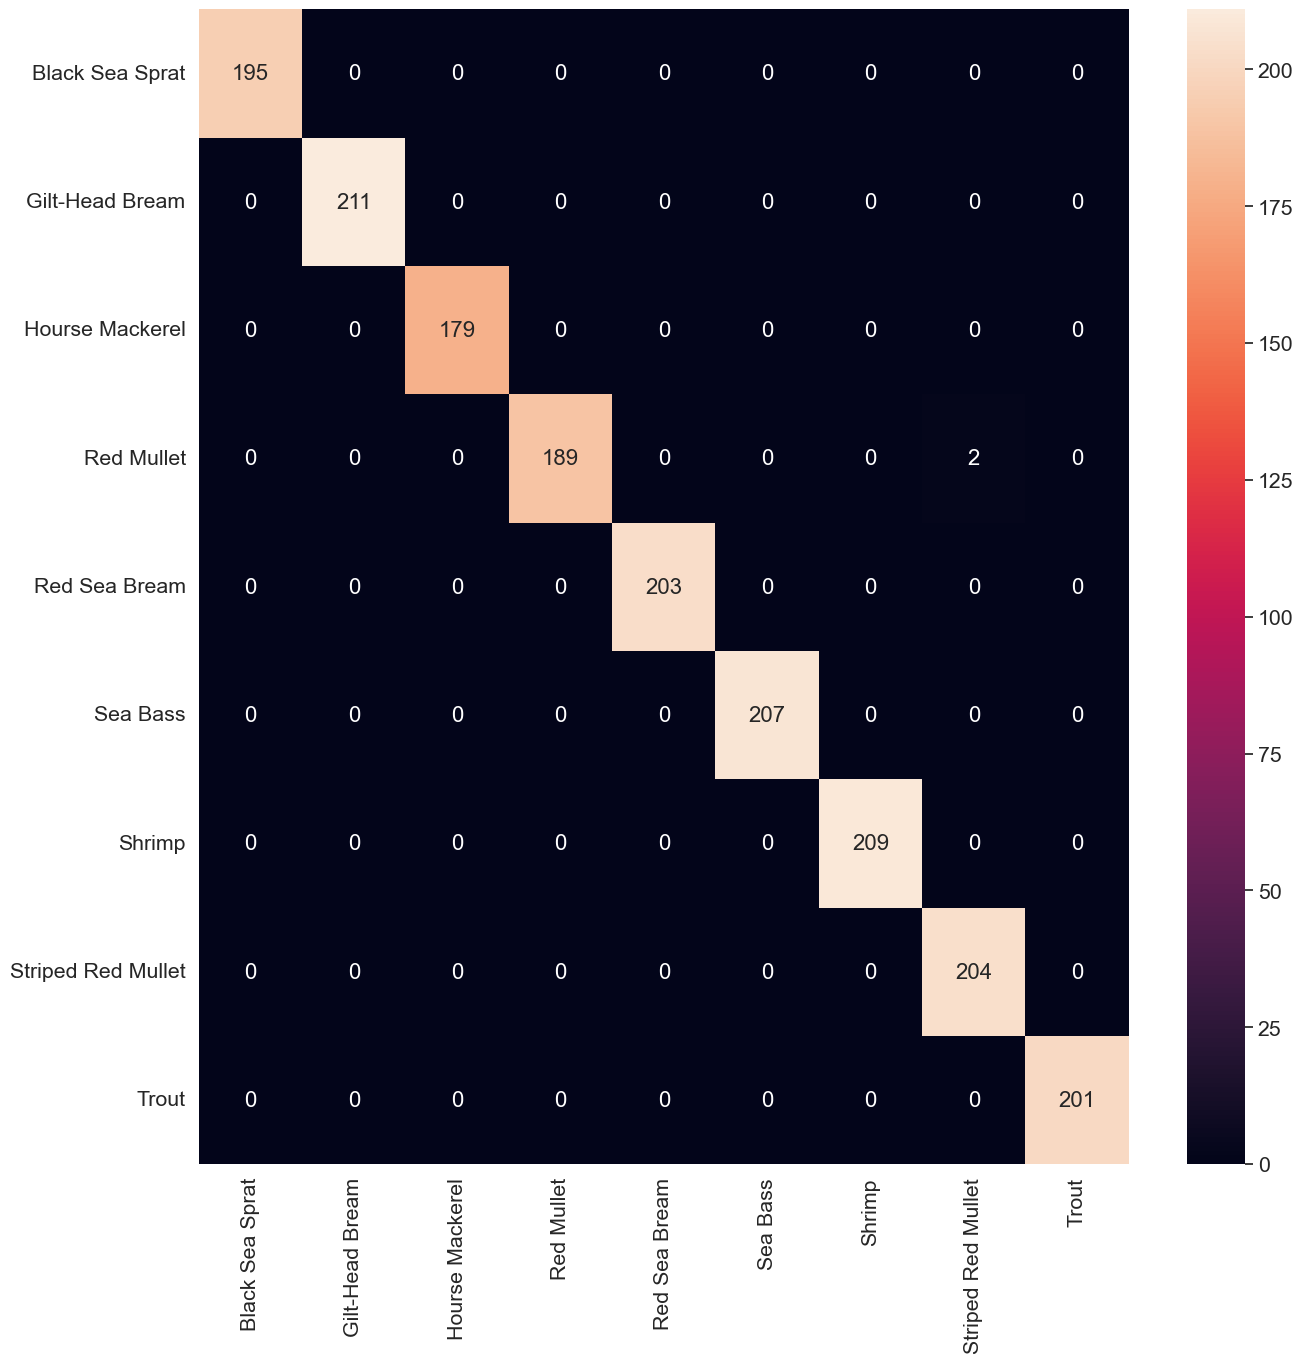

In [11]:
plot_cm(test_labels, prediction_labels, encoder)

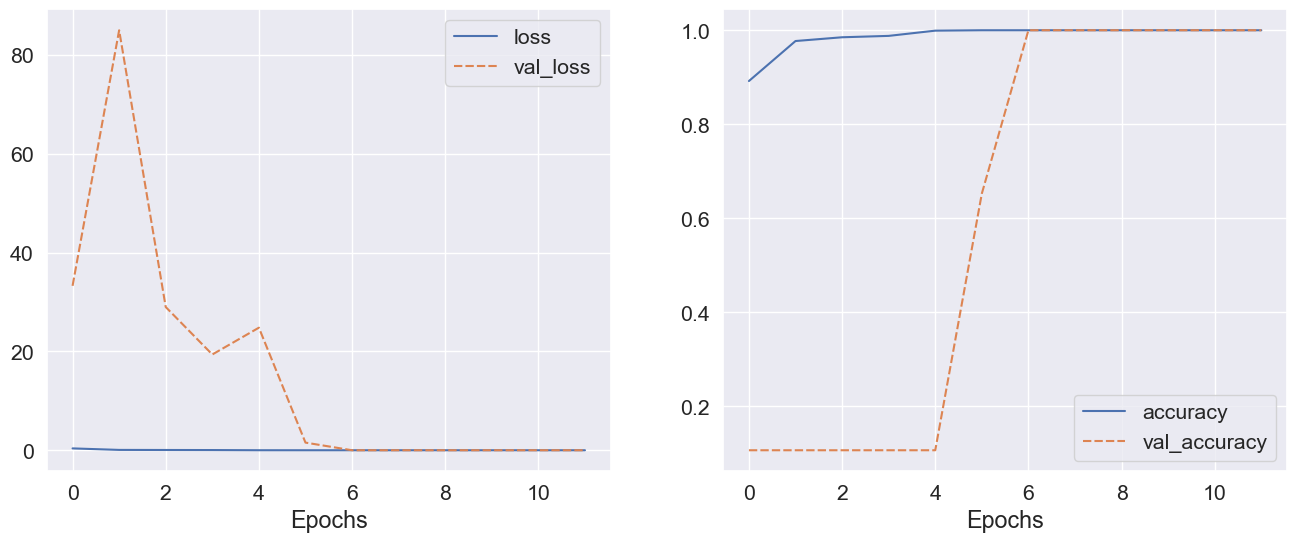

In [15]:
import seaborn as sns
def plot_history2(history):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    history_data = pd.DataFrame(history.history)
    sns.lineplot(data=history_data[['loss','val_loss']],ax=ax[0])
    sns.lineplot(data=history_data[['accuracy','val_accuracy']],ax=ax[1])
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs');
plot_history2(history)

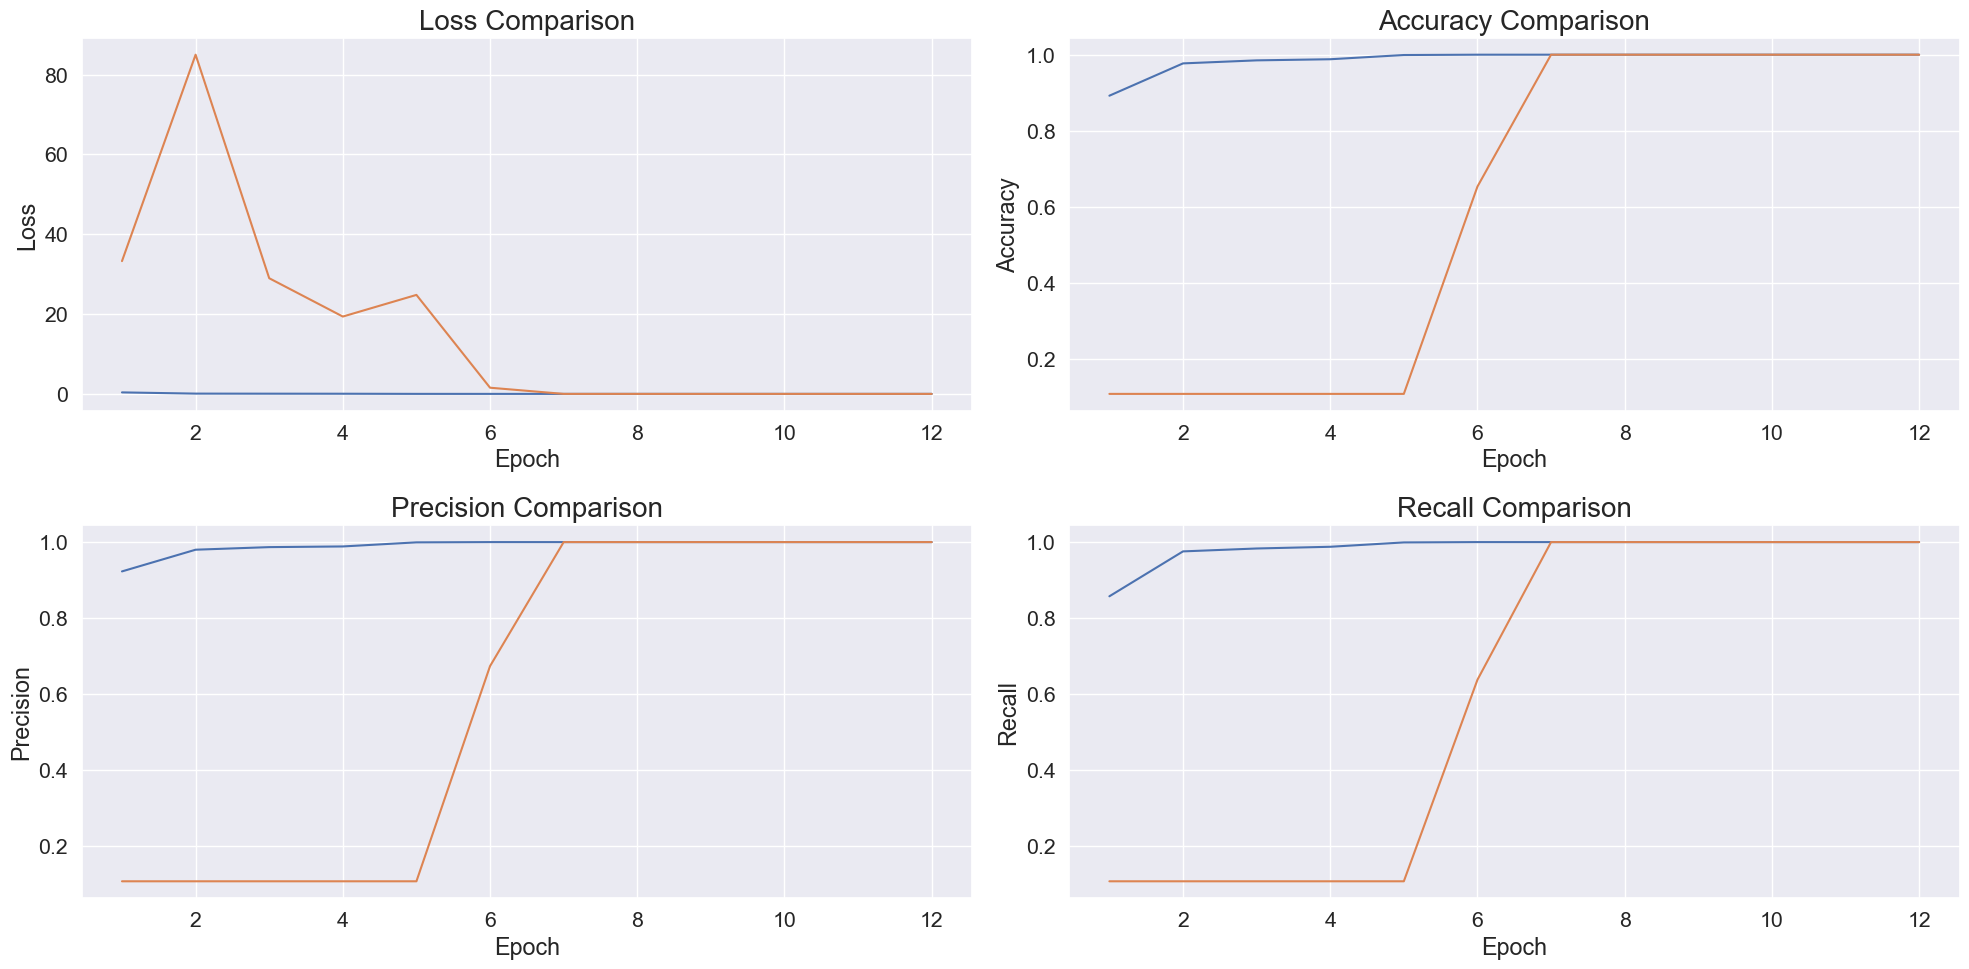

In [18]:
plot_history(history)

In [19]:
model.save("resnet50fishclassification")

INFO:tensorflow:Assets written to: resnet50fishclassification\assets


INFO:tensorflow:Assets written to: resnet50fishclassification\assets
